# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep =';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep =';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("Number of rows and columns for AZDIAS data is " ,azdias.shape)
print("Number of rows and columns for AZDIAS_Feature_Summary data is" , feat_info.shape)

Number of rows and columns for AZDIAS data is  (891221, 85)
Number of rows and columns for AZDIAS_Feature_Summary data is (85, 4)


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
feat_info


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
#Finding out Naturally missing data
#First let us get the count of NaNs for each column
azdias.isnull().sum(axis = 0)

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
#Getting the proportion of Naturally missing values per column
round(azdias.isnull().sum()/azdias.shape[0]*100,2).sort_values(ascending=False)

KK_KUNDENTYP             65.60
KBA05_ANTG3              14.96
KBA05_BAUMAX             14.96
KBA05_GBZ                14.96
KBA05_ANTG2              14.96
KBA05_ANTG1              14.96
MOBI_REGIO               14.96
KBA05_ANTG4              14.96
KKK                      13.60
REGIOTYP                 13.60
PLZ8_ANTG2               13.07
PLZ8_ANTG1               13.07
PLZ8_ANTG3               13.07
PLZ8_ANTG4               13.07
PLZ8_BAUMAX              13.07
PLZ8_HHZ                 13.07
PLZ8_GBZ                 13.07
W_KEIT_KIND_HH           12.07
KBA13_ANZAHL_PKW         11.87
CAMEO_DEUG_2015          11.11
CAMEO_DEU_2015           11.11
CAMEO_INTL_2015          11.11
RELAT_AB                 10.91
ORTSGR_KLS9              10.91
ARBEIT                   10.91
ANZ_HH_TITEL             10.88
BALLRAUM                 10.52
EWDICHTE                 10.52
INNENSTADT               10.52
ANZ_HAUSHALTE_AKTIV      10.45
                         ...  
FINANZ_UNAUFFAELLIGER     0.00
FINANZ_H

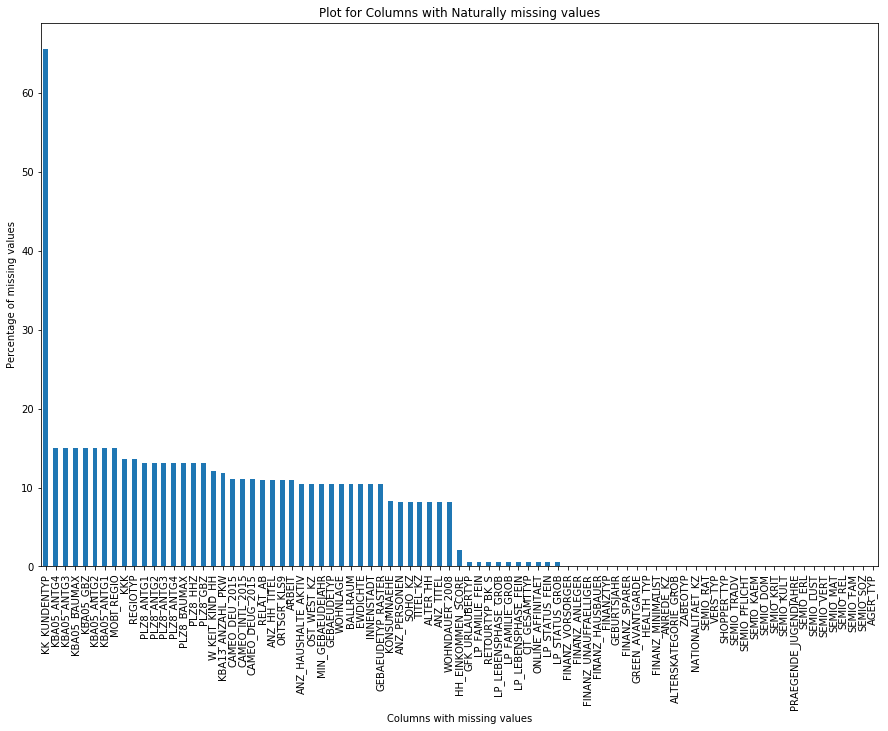

In [10]:
round(azdias.isnull().sum()/azdias.shape[0]*100,1).sort_values(ascending=False).plot.bar(figsize=(15,10))
plt.title('Plot for Columns with Naturally missing values')
plt.xlabel('Columns with missing values')
plt.ylabel('Percentage of missing values')
plt.show()

In [11]:
# Identify missing or unknown data values and convert them to NaNs.
# turn missing_or_unknown to list 
def convert_missing_or_unknown_to_nan(df):
    feat_info['missing_or_unknown_list'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown_list']):
        df.loc[df[attrib].isin(missing_values),attrib]= np.nan

    return df

In [12]:
azdias =convert_missing_or_unknown_to_nan(azdias)

In [13]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum(axis = 0)


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [15]:
# Calculating proportion of values that are missing for each column in descending order
round(azdias.isnull().sum()/azdias.shape[0]*100,2).sort_values(ascending=False)

TITEL_KZ                 99.76
AGER_TYP                 76.96
KK_KUNDENTYP             65.60
KBA05_BAUMAX             53.47
GEBURTSJAHR              44.02
ALTER_HH                 34.81
REGIOTYP                 17.74
KKK                      17.74
W_KEIT_KIND_HH           16.61
KBA05_ANTG4              14.96
KBA05_GBZ                14.96
MOBI_REGIO               14.96
KBA05_ANTG1              14.96
KBA05_ANTG2              14.96
KBA05_ANTG3              14.96
PLZ8_GBZ                 13.07
PLZ8_HHZ                 13.07
PLZ8_BAUMAX              13.07
PLZ8_ANTG4               13.07
PLZ8_ANTG1               13.07
PLZ8_ANTG3               13.07
PLZ8_ANTG2               13.07
SHOPPER_TYP              12.48
VERS_TYP                 12.48
HEALTH_TYP               12.48
NATIONALITAET_KZ         12.15
PRAEGENDE_JUGENDJAHRE    12.14
KBA13_ANZAHL_PKW         11.87
ANZ_HAUSHALTE_AKTIV      11.18
CAMEO_INTL_2015          11.15
                         ...  
LP_STATUS_FEIN            0.54
LP_STATU

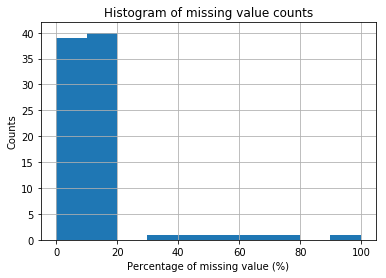

In [16]:
plt.hist(round(azdias.isnull().sum()/azdias.shape[0]*100,1).sort_values(ascending=False))
plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Counts')
plt.title('Histogram of missing value counts')
plt.grid(True)
plt.show()

From the above histogram we can see that columns which has more than 20% missing values are outliers in the data. We need to identify which are these columns and then drop these columns from further analysis

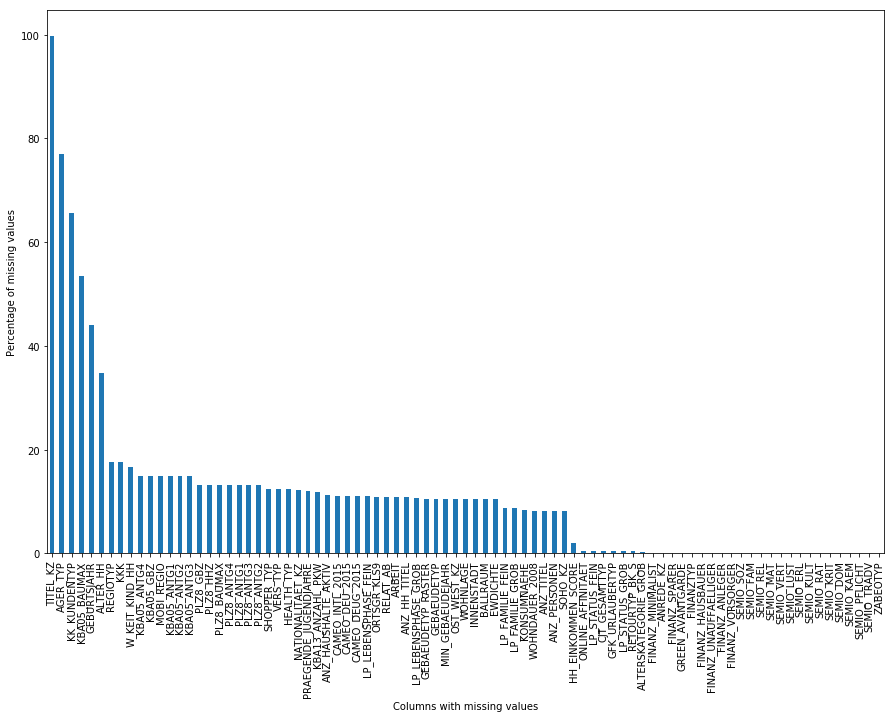

In [17]:
# Investigate patterns in the amount of missing data in each column.
round(azdias.isnull().sum()/azdias.shape[0]*100,1).sort_values(ascending=False).plot.bar(figsize=(15,10))
plt.xlabel('Columns with missing values')
plt.ylabel('Percentage of missing values')
plt.show()


From this plot we can see that there are only 6 columns which has more than 20% missing values . They are TITEL_KZ (Academic title flag), AGER_TYP(Best-ager typology) ,KK_KUNDENTYP (Consumer pattern over past 12 months ) ,KBA05_BAUMAX (Most common building type within the microcell) , GEBURTSJAHR(Year of birth) and ALTER_HH (Birthdate of head of household)

In [18]:
#Getting the unique information levels from the feat_info data

info_level_list = list(feat_info['information_level'].unique())
info_level_list.sort()
print(info_level_list)

['building', 'community', 'household', 'macrocell_plz8', 'microcell_rr3', 'microcell_rr4', 'person', 'postcode', 'region_rr1']


In [19]:
#Creating list of column names belonging to each of the information level group
df =feat_info.groupby('information_level')['attribute'].apply(list)

df

information_level
building          [ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, GEBAEUDETY...
community                           [ARBEIT, ORTSGR_KLS9, RELAT_AB]
household         [ALTER_HH, ANZ_PERSONEN, ANZ_TITEL, HH_EINKOMM...
macrocell_plz8    [KBA13_ANZAHL_PKW, PLZ8_ANTG1, PLZ8_ANTG2, PLZ...
microcell_rr3     [KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_...
microcell_rr4     [CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2...
person            [AGER_TYP, ALTERSKATEGORIE_GROB, ANREDE_KZ, CJ...
postcode                           [BALLRAUM, EWDICHTE, INNENSTADT]
region_rr1        [GEBAEUDETYP_RASTER, KKK, MOBI_REGIO, ONLINE_A...
Name: attribute, dtype: object

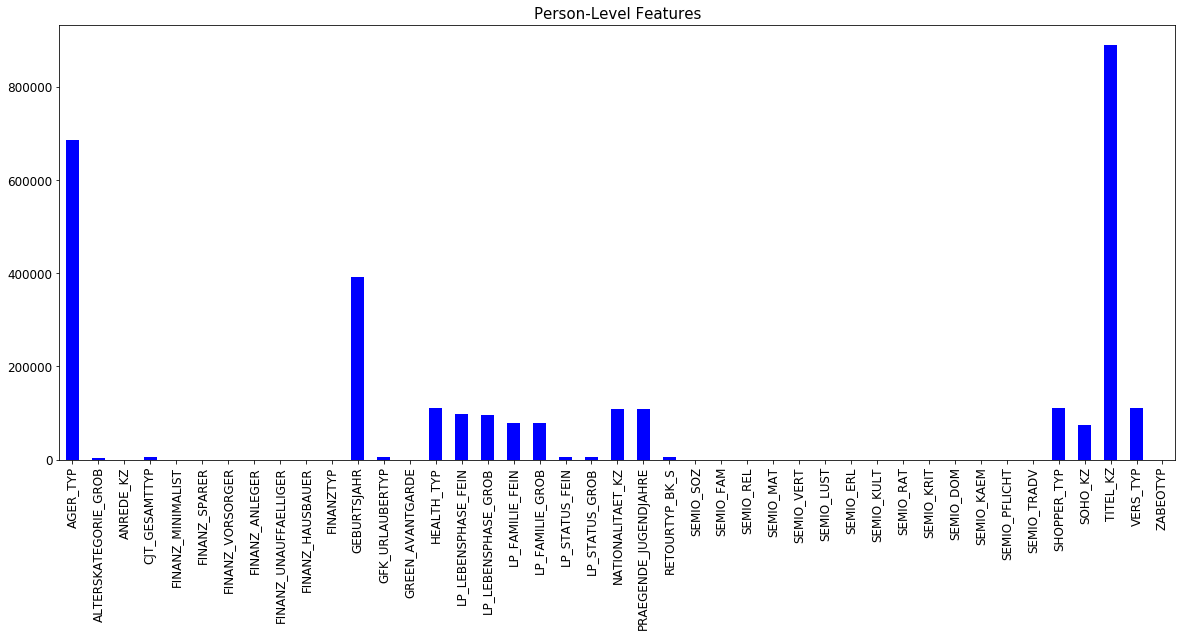

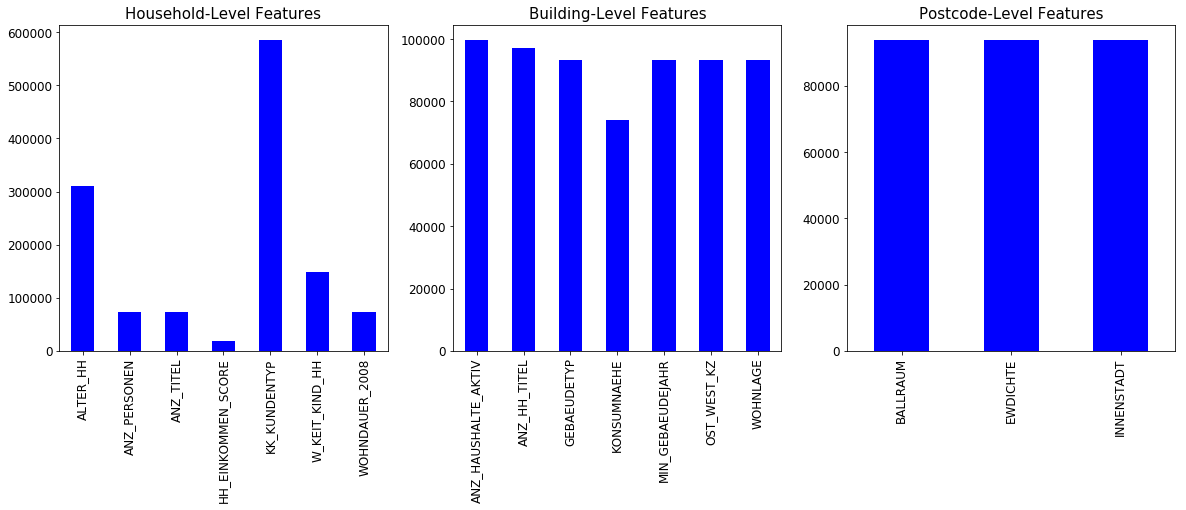

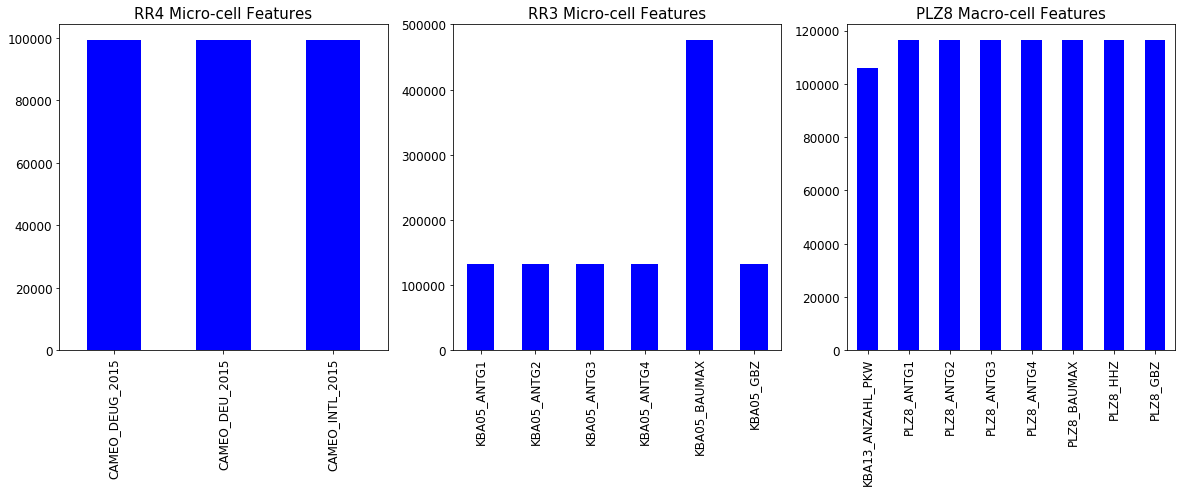

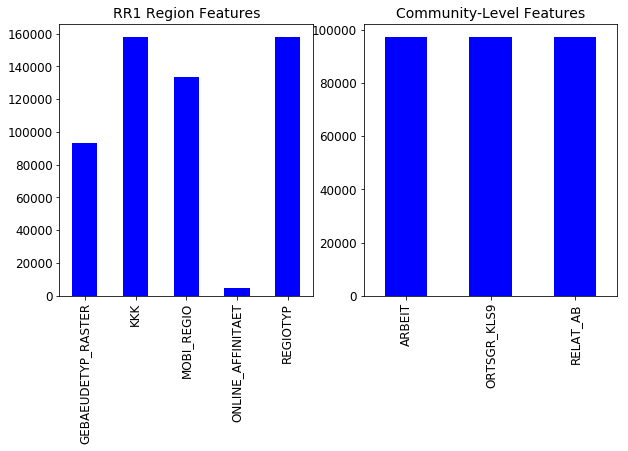

In [20]:
#Investigating the patterns of missing data across columns visually

plt.figure(1,figsize=(20,8))
plt.subplot(111)
azdias[df[6]].isnull().sum().plot.bar(fontsize=12,color='blue')
plt.title('Person-Level Features',fontsize=15)

plt.figure(2,figsize=(20,6))
plt.subplot(131)
azdias[df[2]].isnull().sum().plot.bar(fontsize=12,color='blue')
plt.title('Household-Level Features',fontsize=15)

plt.subplot(132)
azdias[df[0]].isnull().sum().plot.bar(fontsize=12,color='blue')
plt.title('Building-Level Features',fontsize=15)

plt.subplot(133)
azdias[df[7]].isnull().sum().plot.bar(fontsize=12,color='blue')
plt.title('Postcode-Level Features',fontsize=15)

plt.figure(3,figsize=(20,6))
plt.subplot(131)
azdias[df[5]].isnull().sum().plot.bar(fontsize=12,color='blue')
plt.title('RR4 Micro-cell Features',fontsize=15)

plt.subplot(132)
azdias[df[4]].isnull().sum().plot.bar(fontsize=12,color='blue')
plt.title('RR3 Micro-cell Features',fontsize=15)

plt.subplot(133)
azdias[df[3]].isnull().sum().plot.bar(fontsize=12,color='blue')
plt.title('PLZ8 Macro-cell Features',fontsize=15)

plt.figure(4,figsize=(10,5))
plt.subplot(121)
azdias[df[8]].isnull().sum().plot.bar(fontsize=12,color='blue')
plt.title('RR1 Region Features',fontsize=14)

plt.subplot(122)
azdias[df[1]].isnull().sum().plot.bar(fontsize=12,color='blue')
plt.title('Community-Level Features',fontsize=14)

plt.show()

In [21]:
#printing the column names which has more than 20% missing values

print([col for col in azdias.columns if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > 20])


['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Removing columns with more than 20% missing values from the data
azdias = azdias.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'],axis=1)


In [23]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

From analysing missing data across columns we can see that,columns which has more than 20%(or we can say more than 30%) missing values are outliers in the data. There are only 6 columns which has more than 30% missing values . They are TITEL_KZ (Academic title flag), AGER_TYP(Best-ager typology) ,KK_KUNDENTYP (Consumer pattern over past 12 months ) , KBA05_BAUMAX (Most common building type within the microcell) , GEBURTSJAHR(Year of birth) and ALTER_HH (Birthdate of head of household). When we analyzed the natuarally missing values in the data, there was only one column which had more than 20% missing values and that column was KK_KUNDENTYP (Consumer pattern over past 12 months ) which had more than 60% missing values. When we re-encoded all values representing missing values consistently to NaNs , the number of missing percent increased. When we plot that, we can see that 6 columns standing out(which has more than 20%). So it is best to drop these columns from further analysis.

Also when we investigate the missing numbers by information level groups we can see that person - level has the least columns with missing values. Also it has the 3 columns which has missing values more than 20%. (TITEL_KZ, AGER_TYP and GEBURTSJAHR).
Most of the feature level groups appear to have similar percent of missing values. Specially, micro cell features, macro cell features, community level features and post code level features, also to an extent Building level features.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis = 1).value_counts().sort_values(ascending=False)


0     623209
47     45578
2      27926
43     27369
8      24592
5      22515
3      17629
1      15738
6      13771
7      13714
4      12607
34     10816
10      5410
15      4743
35      3911
13      3255
9       3042
33      2985
16      2505
14      2243
19      1180
11      1127
12       766
17       677
37       538
45       494
18       428
38       421
41       356
20       349
32       206
44       155
21       150
40       137
23       132
22       129
36        84
39        77
24        69
26        59
25        55
27        24
42        21
29        12
30         6
28         5
31         3
49         2
48         1
dtype: int64

In [25]:
#Count of missing values per row
mi_per_row = pd.crosstab(azdias.isnull().sum(axis = 1),columns="count")
mi_per_row

col_0,count
row_0,
0,623209
1,15738
2,27926
3,17629
4,12607
5,22515
6,13771
7,13714
8,24592


In [26]:
mi_per_row['percentage'] =round(mi_per_row/mi_per_row.sum() *100,2)
mi_per_row['cum_percentage']=round(mi_per_row['count'].cumsum()/mi_per_row['count'].sum() *100,2)
mi_per_row

col_0,count,percentage,cum_percentage
row_0,,,
0,623209,69.93,69.93
1,15738,1.77,71.69
2,27926,3.13,74.83
3,17629,1.98,76.80
4,12607,1.41,78.22
5,22515,2.53,80.75
6,13771,1.55,82.29
7,13714,1.54,83.83
8,24592,2.76,86.59


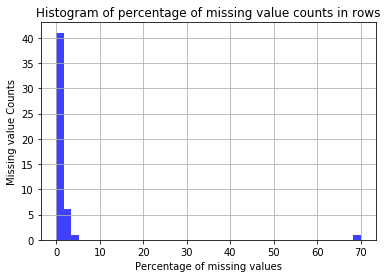

In [27]:
plt.hist(mi_per_row['percentage'], bins=40, facecolor='b', alpha=0.75)
plt.xlabel('Percentage of missing values')
plt.ylabel('Missing value Counts')
plt.title('Histogram of percentage of missing value counts in rows')
plt.grid(True)
plt.show()

From the above we can see that 69.93 % of the data is complete , ie with 0 missing values per row.
So if we drop all the incomplete rows, then also we will get almost 70% of the data, which is very reasonable. So lets check the distribution of values of 5 columns where there are no or few missing values between the complete and incomplete datasets.

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_complete = azdias[azdias.isnull().sum(axis =1)==0]
azdias_incomplete = azdias[azdias.isnull().sum(axis =1)>0]
print(azdias_complete.shape)
print(azdias_incomplete.shape)

(623209, 79)
(268012, 79)


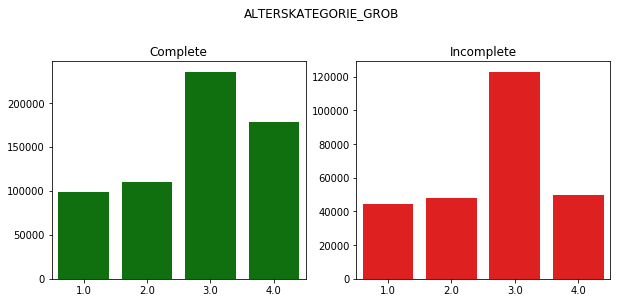

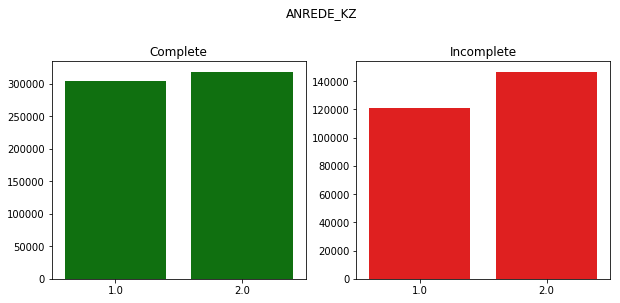

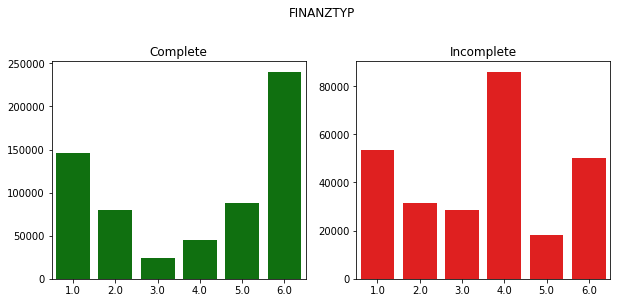

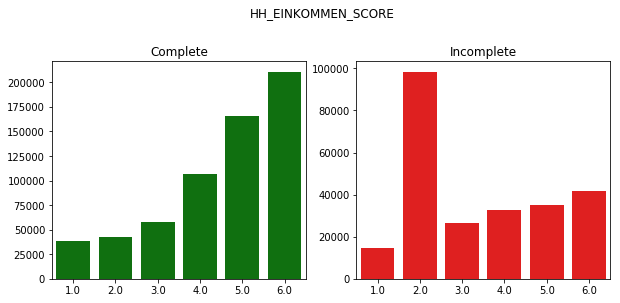

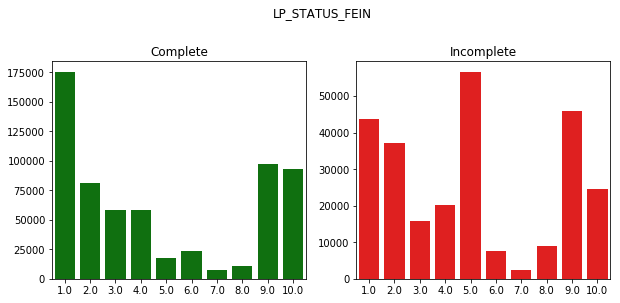

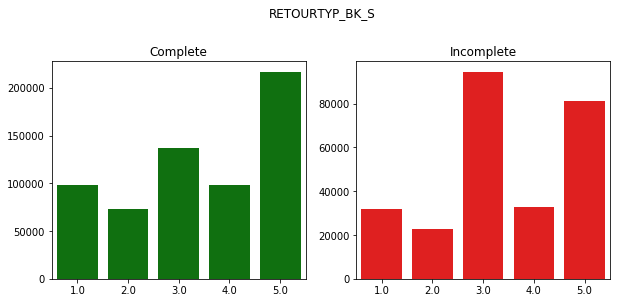

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
#Manually selected 5 columns which have no or few missing values and which I felt are giving important information 
# like age, gender, financial type, household income , social status and return type
col_names =['ALTERSKATEGORIE_GROB','ANREDE_KZ','FINANZTYP','HH_EINKOMMEN_SCORE','LP_STATUS_FEIN','RETOURTYP_BK_S']
for col in col_names:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=azdias_complete, color='green')
    plt.title('Complete')
    plt.xlabel('')
    plt.ylabel('')
    plt.subplot(1, 2, 2)
    sns.countplot(x=col, data=azdias_incomplete, color='red')
    plt.title('Incomplete')
    plt.xlabel('')
    plt.ylabel('')
    plt.suptitle(col, y=1.07)
    plt.show()

From the above graphs we can see that there are some differences on the distribution in complete and incomplete data. Specially for household income, financial type ,social status etc. So these need further investigation before dropping

In [30]:
#Investigating the household income and social status variable further
print("Percentage of missing values for Household income variable in the incomplete data is",round(azdias_incomplete['HH_EINKOMMEN_SCORE'].isnull().sum()/azdias_incomplete.shape[0] *100,2))
print("Percentage of very high income group in the incomplete data is", round((azdias_incomplete['HH_EINKOMMEN_SCORE'] == 2).sum()/azdias_incomplete.shape[0] *100,2))
print("Percentage of missing values for Social status variable in the incomplete data is",round(azdias_incomplete['LP_STATUS_FEIN'].isnull().sum()/azdias_incomplete.shape[0] *100,2))
print("Percentage of minimalistic high-income earners in the incomplete data is", round((azdias_incomplete['LP_STATUS_FEIN'] == 5).sum()/azdias_incomplete.shape[0] *100,2))

Percentage of missing values for Household income variable in the incomplete data is 6.85
Percentage of very high income group in the incomplete data is 36.71
Percentage of missing values for Social status variable in the incomplete data is 1.81
Percentage of minimalistic high-income earners in the incomplete data is 21.13


In [31]:
pd.crosstab(index = azdias_incomplete['HH_EINKOMMEN_SCORE'],columns="count")

col_0,count
HH_EINKOMMEN_SCORE,
1.0,14786
2.0,98392
3.0,26476
4.0,32881
5.0,35223
6.0,41906


In [32]:
pd.crosstab(index = azdias_incomplete['LP_STATUS_FEIN'],columns="count")

col_0,count
LP_STATUS_FEIN,
1.0,43711
2.0,37220
3.0,15771
4.0,20309
5.0,56623
6.0,7611
7.0,2508
8.0,8966
9.0,45888


#### Discussion 1.1.3: Assess Missing Data in Each Row

From the analysis of Missing Data in each row, we can see that 69.93 % of the data is complete , ie with 0 missing values per row.So even if we drop all the incomplete rows, then also we will get almost 70% of the data, which is very reasonable. 
To check the distribution of values of 5 columns where there are no or few missing values between the complete and incomplete datasets,I manually selected 5 columns which have no or few missing values and which I felt are giving important information like age, gender, financial type, household income , social status and return type
From, this assesment we can see that there are some qualitative differences.

For eg: Household income : In the incomplete data , the majority constitutes Very high income group.
Same thing is coming through the variable social status . For this also in the incomplete data the larger population is minimalistic high income earners. 

Also the missing percentage for household income variable in the incomplete data is around 7% and social status variable is approx just 2% . So this indicates we may lose lot of information about these variables if we ignore all the rows with some missing values, that too useful information, because high income groups will be a potential target group for the company. So at this point we will leave it as it is and continue to use the complete data and come back and investigate this further at a later stage.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
pd.crosstab(index = feat_info['type'],columns="count")


col_0,count
type,
categorical,21
interval,1
mixed,7
numeric,7
ordinal,49


Out of these we have dropped 6 columns . So dropping that from feat_info attributes ,and checking the numbers again

In [34]:
drop_list =['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
feat_info_nw = feat_info[~feat_info['attribute'].isin(drop_list)]
feat_info_nw.shape


(79, 5)

In [35]:
pd.crosstab(index = feat_info_nw['type'],columns="count")

col_0,count
type,
categorical,18
mixed,6
numeric,6
ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
azdias_ctg = azdias_complete[feat_info_nw[feat_info_nw['type'] == 'categorical']['attribute']]
azdias_ctg.shape
ctg_list =list(azdias_ctg.columns)
ctg_list

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [37]:
binary_list = []
multilevel_list = []
for col in ctg_list:
    if len(azdias_ctg[col].value_counts()) == 2:
        binary_list.append(col)
    else:
        multilevel_list.append(col)
print("binary_list is ", binary_list)
print("multilevel_list is ", multilevel_list)

binary_list is  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
multilevel_list is  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [38]:
azdias_ctg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 18 columns):
ANREDE_KZ           623209 non-null float64
CJT_GESAMTTYP       623209 non-null float64
FINANZTYP           623209 non-null float64
GFK_URLAUBERTYP     623209 non-null float64
GREEN_AVANTGARDE    623209 non-null float64
LP_FAMILIE_FEIN     623209 non-null float64
LP_FAMILIE_GROB     623209 non-null float64
LP_STATUS_FEIN      623209 non-null float64
LP_STATUS_GROB      623209 non-null float64
NATIONALITAET_KZ    623209 non-null float64
SHOPPER_TYP         623209 non-null float64
SOHO_KZ             623209 non-null float64
VERS_TYP            623209 non-null float64
ZABEOTYP            623209 non-null float64
GEBAEUDETYP         623209 non-null float64
OST_WEST_KZ         623209 non-null object
CAMEO_DEUG_2015     623209 non-null object
CAMEO_DEU_2015      623209 non-null object
dtypes: float64(15), object(3)
memory usage: 110.3+ MB


Of the binary columns only OST_WEST_KZ is non numeric . It indicates Building location via former East / West Germany (GDR / FRG)  O : EAST(GDR) and W :WEST(FRG).
So I decided to re-encode it into nuemric variable . ie 0 as East(GDR) and 1 as WEST(FRG)

In [39]:
#re-encode it into nuemric variable
azdias_complete['OST_WEST_KZ'] = azdias_complete['OST_WEST_KZ'].map({'W': 1, 'O': 0})
azdias_complete['OST_WEST_KZ'].unique()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([1, 0])

In [40]:
azdias_complete['CAMEO_DEUG_2015'].value_counts() #Appears to have a decent distribution so we can keep it

8    113915
9     87295
6     87089
4     80020
3     63525
7     61735
2     59442
5     41070
1     29118
Name: CAMEO_DEUG_2015, dtype: int64

In [41]:
azdias_complete['GEBAEUDETYP'].value_counts() # Here better to keep indicator variable only for Values 1 -Residential building and 3- Mixed(Residential and Company)
azdias_complete['GEBAEUDETYP_1'] = np.where(azdias_complete['GEBAEUDETYP']==1, 1, 0)
azdias_complete['GEBAEUDETYP_3'] = np.where(azdias_complete['GEBAEUDETYP']==3, 1, 0)
azdias_complete.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GEBAEUDETYP_1,GEBAEUDETYP_3
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1,0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,1,0


In [42]:
azdias_complete['ZABEOTYP'].value_counts() #Keep it

3.0    223164
4.0    168631
1.0     93587
5.0     63604
6.0     54418
2.0     19805
Name: ZABEOTYP, dtype: int64

In [43]:
azdias_complete['SHOPPER_TYP'].value_counts()#Keep it

1.0    191885
2.0    177074
3.0    142655
0.0    111595
Name: SHOPPER_TYP, dtype: int64

In [44]:
azdias_complete['NATIONALITAET_KZ'].value_counts() #Nationality based on given name analysis. So I don't thinkit is useful. So drop it

1.0    543405
2.0     53856
3.0     25948
Name: NATIONALITAET_KZ, dtype: int64

LP_STATUS_GROB and LP_STATUS_FEIN tells the same thing. So keep only one. Decided to keep LP_STATUS_GROB as it has lower levels
Same is the case for LP_FAMILIE_GROB and LP_FAMILIE_FEIN . so keeping only LP_FAMILIE_GROB Also decided to keep CJT_GESAMTTYP and FINANZTYP

In [45]:
azdias_complete['GFK_URLAUBERTYP'].value_counts() #Keep

12.0    98076
10.0    81624
8.0     69405
11.0    60164
5.0     57326
4.0     51615
3.0     44233
9.0     41272
1.0     39929
7.0     31423
2.0     27430
6.0     20712
Name: GFK_URLAUBERTYP, dtype: int64

In [46]:
#Drop multilevel vars which are not required
Drop_vars = ['CAMEO_DEU_2015','GEBAEUDETYP','NATIONALITAET_KZ','LP_STATUS_FEIN','LP_FAMILIE_FEIN']
multi_list_nw = [x for x in multilevel_list if x not in Drop_vars]
multi_list_nw

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'CAMEO_DEUG_2015']

In [47]:
# Re-encode categorical variable(s) to be kept in the analysis.
# One Hot Encoding for remaining multilevel categorical variables
azdias_complete = pd.get_dummies(azdias_complete, columns = multi_list_nw, prefix=multi_list_nw)
azdias_complete = azdias_complete.drop(Drop_vars,axis=1)

In [48]:
azdias_complete.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_6.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,0,0,0,0,1,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,1,0,0,0,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,0,0,0,0,0,1,0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0,0,0,0,1,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

There were 18 categorical variables. Out of which 5 are binary and remaining are multi level variables.
- Of the 5 binary variables, the variable OST_WEST_KZ was non numeric. So I decided to re-encode it into nuemric variable . ie   0 as East(GDR) and 1 as WEST(FRG). 
- The rest of the binary numeric variables I kept as it is.

Then I analyzed each of the multi level variables.
- Variables CAMEO_DEUG_2015 and CAMEO_DEU_2015 , both are talking about Wealth / Life Stage Typology. One on a rough level and the other on a more finer level. So kept CAMEO_DEUG_2015 (rough level) as it has lower levels
- Similarly for vars LP_STATUS (Social status) and LP_FAMILIE (Family type) , _FEIN and _GROB , kept only _GROB , because of the same reason as above.
- All of the finer tuning we can look later, if required.
- For the GEBAEUDETYP (Type of building (residential vs. commercial) most of the values were only for 1-Residential and 3- Mixed (Residential and Company). So created indicator variables only for those.
- NATIONALITAET_KZ (Nationality based on given name analysis) , I felt it is not that useful. So decided to drop the same.
- The rest of the variables ['CJT_GESAMTTYP','FINANZTYP', GFK_URLAUBERTYP','SHOPPER_TYP', 'ZABEOTYP'] decided to keep all these.
- So all these variables as well as the ones mentioned above, I created dummy variables using one-hot encoding


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
#Getting columns with mixed types
list(feat_info[feat_info['type'] == 'mixed'].attribute)

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [50]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_complete['PRAEGENDE_JUGENDJAHRE'].value_counts()


14.0    144627
8.0     114745
5.0      69527
10.0     68820
3.0      44103
15.0     33585
9.0      29033
11.0     28375
6.0      22802
12.0     19933
4.0      18371
1.0      15233
2.0       6189
13.0      4450
7.0       3416
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [51]:
#Since more contribution is for the mainstream variable, decided to name the new binary variable to be be MAINSTREAM
MAINSTREAM = []

for x in azdias_complete['PRAEGENDE_JUGENDJAHRE']:
    if x in [1,3,5,8,10,12,14]:
        MAINSTREAM.append(1) 
    else:
        MAINSTREAM.append(0)
        
mov_var = pd.Series(MAINSTREAM)
azdias_complete['MAINSTREAM'] = mov_var.values
azdias_complete.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,0,0,0,1,0,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,1,0,0,0,0,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,0,0,1,0,0,0,1
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,0,0,0,0,1,0,1
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0,0,0,1,0,0,0,0,0,1


In [52]:
# Create a new column "GEN_DECADE" based on decade of birth from the PRAEGENDE_JUGENDJAHRE column
# Mapping 40s to 1, 50s to 2, 60s to 3,70s to 4, 80s to 5 and 90s to 6
map_dict ={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
azdias_complete['DECADE'] = azdias_complete['PRAEGENDE_JUGENDJAHRE'].map(map_dict)
azdias_complete.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM,DECADE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,0,0,1,0,1,6
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,1,0,0,0,0,0,0,6
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,0,1,0,0,0,1,4
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,0,0,0,1,0,1,2
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0,0,1,0,0,0,0,0,1,5


In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_complete['CAMEO_INTL_2015'].value_counts()


51    111261
41     74647
24     73984
14     48465
43     46538
54     37893
25     30969
22     23899
45     22025
13     19617
55     18638
52     16677
34     15112
23     14693
15     13578
31     12370
44     12060
35      8380
32      8071
33      7432
12      6900
Name: CAMEO_INTL_2015, dtype: int64

In [54]:
azdias_complete['CAMEO_WEALTH'] = azdias_complete['CAMEO_INTL_2015'].str[:1]
azdias_complete['CAMEO_LIFESTAGE'] = azdias_complete['CAMEO_INTL_2015'].str[-1]

In [55]:
azdias_complete[['CAMEO_INTL_2015','CAMEO_WEALTH','CAMEO_LIFESTAGE']].head()

,CAMEO_INTL_2015,CAMEO_WEALTH,CAMEO_LIFESTAGE
1,51,5,1
2,24,2,4
4,43,4,3
5,54,5,4
6,22,2,2


In [56]:
azdias_complete[['CAMEO_WEALTH','CAMEO_LIFESTAGE']]  = azdias_complete[['CAMEO_WEALTH','CAMEO_LIFESTAGE']].convert_objects(convert_numeric=True)
azdias_complete.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,1,0,1,6,5,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1,0,0,0,0,0,0,6,2,4
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,1,0,0,0,1,4,4,3
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,0,1,0,1,2,5,4
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,1,0,0,0,0,0,1,5,2,2


In [57]:
azdias_complete[['MAINSTREAM','DECADE','CAMEO_INTL_2015','CAMEO_WEALTH','CAMEO_LIFESTAGE']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 5 columns):
MAINSTREAM         623209 non-null int64
DECADE             623209 non-null int64
CAMEO_INTL_2015    623209 non-null object
CAMEO_WEALTH       623209 non-null int64
CAMEO_LIFESTAGE    623209 non-null int64
dtypes: int64(4), object(1)
memory usage: 48.5+ MB


In [58]:
azdias_complete['CAMEO_WEALTH'].value_counts()

5    184469
4    155270
2    143545
1     88560
3     51365
Name: CAMEO_WEALTH, dtype: int64

In [59]:
azdias_complete['CAMEO_LIFESTAGE'].value_counts()

1    198278
4    187514
5     93590
3     88280
2     55547
Name: CAMEO_LIFESTAGE, dtype: int64

In [60]:
azdias_complete['WOHNLAGE'].value_counts()

3.0    204534
7.0    132068
4.0    109059
2.0     79948
5.0     56113
1.0     36612
8.0      4871
0.0         4
Name: WOHNLAGE, dtype: int64

In [61]:
#Create rural flag variables from WOHNLAGE and keeping wohnlage as it is as Neighbourhood quality

azdias_complete['RURAL_FLAG'] = azdias_complete['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
azdias_complete[['WOHNLAGE','RURAL_FLAG']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 2 columns):
WOHNLAGE      623209 non-null float64
RURAL_FLAG    623209 non-null int64
dtypes: float64(1), int64(1)
memory usage: 34.3 MB


In [62]:
azdias_complete['RURAL_FLAG'].unique()
azdias_complete.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL_FLAG
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,1,0,1,6,5,1,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,0,0,6,2,4,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,1,0,0,0,1,4,4,3,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,1,0,1,2,5,4,1
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0,0,0,0,0,1,5,2,2,0


In [63]:
# Drop mixed features not required
azdias_complete = azdias_complete.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE','PLZ8_BAUMAX','CAMEO_INTL_2015'],axis=1)

In [64]:
azdias_complete.shape

(623209, 121)

In [65]:
azdias_complete.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL_FLAG
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,1,0,1,6,5,1,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,0,0,6,2,4,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,1,0,0,0,1,4,4,3,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,1,0,1,2,5,4,1
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0,0,0,0,0,1,5,2,2,0


#### Discussion 1.2.2: Engineer Mixed-Type Features
The columns with mixed type are 'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE','WOHNLAGE', 'CAMEO_INTL_2015','KBA05_BAUMAX','PLZ8_BAUMAX'

Four new variables were reengineered from the variables PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. 
MAINSTREAM and DECADE from PRAEGENDE_JUGENDJAHRE and CAMEO_WEALTH and CAMEO_LIFESTAGE from CAMEO_INTL_2015.

From the other mixed type variables, I created an indicator variable , RURAL_FLAG from the WOHNLAGE variable (Neighborhood quality (or rural flag)) and kept the wohnlage as it is , as Neighbourhood quality.

From the rest KBA05_BAUMAX is already dropped. I also dropped the other columns as I felt we are getting same or almost same information from some other features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [66]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    feat_info['missing_or_unknown_list'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown_list']):
        df.loc[df[attrib].isin(missing_values),attrib]= np.nan

       
    # remove selected columns and rows, ...
    df = df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'],axis=1)
    df_complete = df[df.isnull().sum(axis =1)==0]
    df_incomplete = df[df.isnull().sum(axis =1)>0]
    
    # select, re-encode, and engineer column values.
    df_complete['OST_WEST_KZ'] = df_complete['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    df_complete['GEBAEUDETYP_1'] = np.where(df_complete['GEBAEUDETYP']==1, 1, 0)
    df_complete['GEBAEUDETYP_3'] = np.where(df_complete['GEBAEUDETYP']==3, 1, 0)
    
    multi_list_nw = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_GROB','LP_STATUS_GROB','SHOPPER_TYP','ZABEOTYP','CAMEO_DEUG_2015']
    Drop_vars = ['CAMEO_DEU_2015','GEBAEUDETYP','NATIONALITAET_KZ','LP_STATUS_FEIN','LP_FAMILIE_FEIN']
    df_complete = pd.get_dummies(df_complete, columns = multi_list_nw, prefix=multi_list_nw)
    df_complete = df_complete.drop(Drop_vars,axis=1)
    
    MAINSTREAM = []

    for x in df_complete['PRAEGENDE_JUGENDJAHRE']:
        if x in [1,3,5,8,10,12,14]:
            MAINSTREAM.append(1) 
        else:
            MAINSTREAM.append(0)
    mov_var = pd.Series(MAINSTREAM)
    df_complete['MAINSTREAM'] = mov_var.values
    map_dict ={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    df_complete['DECADE'] = df_complete['PRAEGENDE_JUGENDJAHRE'].map(map_dict)
    df_complete['CAMEO_WEALTH'] = df_complete['CAMEO_INTL_2015'].str[:1]
    df_complete['CAMEO_LIFESTAGE'] = df_complete['CAMEO_INTL_2015'].str[-1]
    df_complete[['CAMEO_WEALTH','CAMEO_LIFESTAGE']]  = df_complete[['CAMEO_WEALTH','CAMEO_LIFESTAGE']].convert_objects(convert_numeric=True)
    df_complete['RURAL_FLAG'] = df_complete['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df_complete = df_complete.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE','PLZ8_BAUMAX','CAMEO_INTL_2015'],axis=1)
    # Return the cleaned dataframe.
    
    return df_complete , df_incomplete

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [67]:
# Apply feature scaling to the general population demographics data.
scaler =StandardScaler()
azdias_complete_1 = scaler.fit_transform(azdias_complete)
azdias_complete_2 =pd.DataFrame(azdias_complete_1,columns=azdias_complete.columns)
azdias_complete_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL_FLAG
0,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,-0.265613,-0.403042,-0.33159,2.114432,-0.403596,0.553670,1.164454,1.147882,-1.251108,-0.530670
1,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.265613,-0.403042,-0.33159,-0.472940,-0.403596,-1.806129,1.164454,-0.909997,0.749822,-0.530670
2,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,-0.265613,2.481129,-0.33159,-0.472940,-0.403596,0.553670,-0.213400,0.461922,0.082845,-0.530670
3,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,-0.265613,-0.403042,-0.33159,2.114432,-0.403596,0.553670,-1.591253,1.147882,0.749822,1.884409
4,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,-0.265613,-0.403042,-0.33159,-0.472940,-0.403596,0.553670,0.475527,-0.909997,-0.584131,-0.530670


### Discussion 2.1: Apply Feature Scaling

I had used only complete rows(rows with no missing values).  So there was no need to do any missing imputations before feature scaling. For feature scaling I have used the StandardScalar method. By viewing the first few rows of the transformed data , we can see the transformations.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [68]:
# Apply PCA to the data.
def do_pca(n_components,data):
    '''
    Transforms data using PCA to create n_components and provides back the results of the transformation
    INPUT:  n_components - int - the number of principal components to create
            data - the data you would like to transform
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    #X = StandardScaler().fit_transform(data)  #This line is commented out as we had already done the feature scaling
    X = data
    pca = PCA(n_components,whiten=True,random_state=42)
    X_pca = pca.fit_transform(X)
    return pca, X_pca


In [69]:
pca, azdias_complete_pca = do_pca(121,azdias_complete_1)

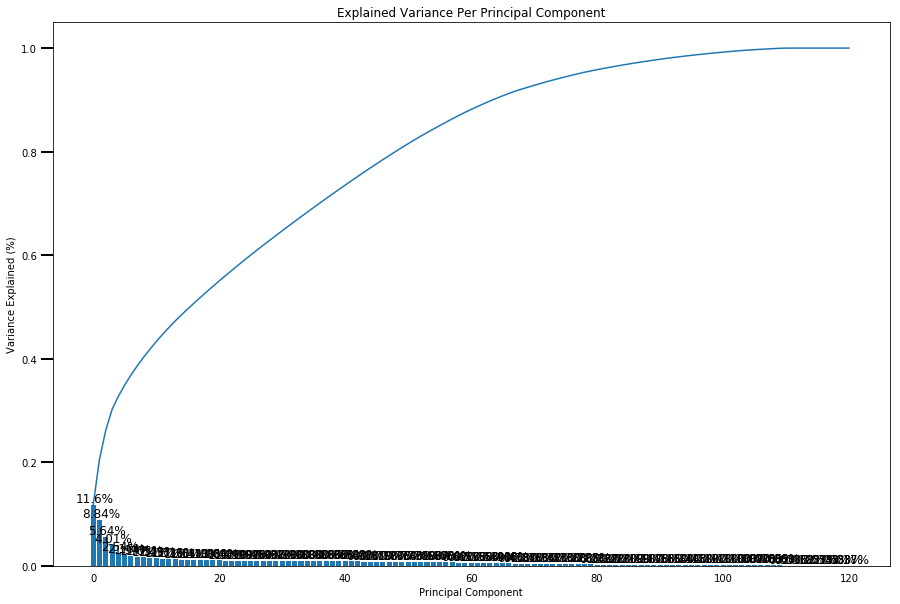

In [70]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15,10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)


In [71]:
pca_var_ratio = pca.explained_variance_ratio_ .tolist()
pca_var_ratio

[0.11684055198588367,
 0.08842299097091806,
 0.05643607259748326,
 0.04010472630870058,
 0.025470311042205027,
 0.02169183856938029,
 0.01948377740624236,
 0.01770094848529747,
 0.016555626806561606,
 0.015264571013531455,
 0.014999900750601433,
 0.013780853205578134,
 0.013113229221694861,
 0.012609590269395139,
 0.012023960413294121,
 0.011450798141401146,
 0.011138845489054874,
 0.011025987221445752,
 0.010886475939439895,
 0.010694782666857855,
 0.010470469752493966,
 0.010222059460281539,
 0.010141265137051726,
 0.009972602688237938,
 0.009936148568812324,
 0.009741065917798414,
 0.00955722109933813,
 0.009422502153314947,
 0.009340669352089805,
 0.009260931027812492,
 0.009239116152318469,
 0.009148615083391272,
 0.009090106324965395,
 0.009019894568430473,
 0.008868975607625923,
 0.008847278060272778,
 0.008826351620396215,
 0.008656657852681056,
 0.008643592525772239,
 0.008620177424218774,
 0.008555175941806428,
 0.008446714894294508,
 0.008321319484985079,
 0.0082982429493631

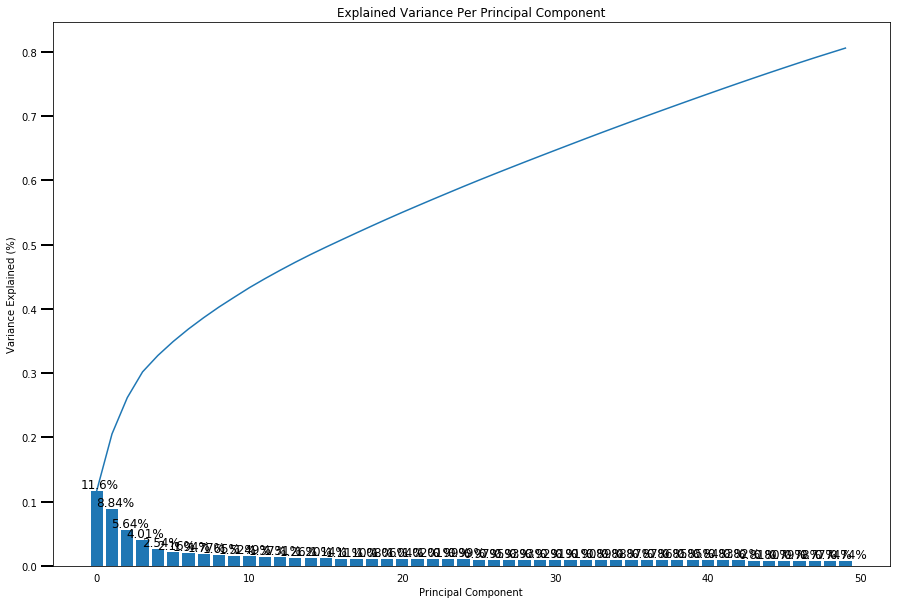

In [72]:
# Re-apply PCA to the data while selecting for number of components to retain.
#We can see that almost 80% of the variance is explained by 50 principal components
pca, azdias_complete_pca = do_pca(50,azdias_complete_1)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

Initially I did the PCA with all the components(121). From the scree plot we can see that the first 10 principal components explain almost 40% variation . The first 18 components explain almost 50% of the variation. Almost 80% of the variance is explained by 50 principal components. So I decided to go with 50 principal components, so that we are not losing much information.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [73]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_feature_weights(principal_component):
    weights = pd.DataFrame(pca.components_,columns = azdias_complete.columns, index = range(1,len(pca.components_)+1)).T.add_prefix("PC_")
    weights_sorted = weights.sort_values(weights.columns[principal_component-1],ascending=False)
    print("Top 5 features with positive weights for PC_",principal_component, " are")
    print("-"*50)
    print(weights_sorted.iloc[:,principal_component-1].head())
    print("-"*50)
    print("-"*50)
    weights_sorted = weights.sort_values(weights.columns[principal_component-1])
    print("Top 5 features with negative weights for PC_",principal_component, " are")
    print(weights_sorted.iloc[:,principal_component-1].head())
    
get_feature_weights(1)

Top 5 features with positive weights for PC_ 1  are
--------------------------------------------------
LP_STATUS_GROB_1.0    0.196077
PLZ8_ANTG3            0.185699
CAMEO_WEALTH          0.179952
HH_EINKOMMEN_SCORE    0.179946
PLZ8_ANTG4            0.179636
Name: PC_1, dtype: float64
--------------------------------------------------
--------------------------------------------------
Top 5 features with negative weights for PC_ 1  are
MOBI_REGIO          -0.207843
FINANZ_MINIMALIST   -0.205324
KBA05_ANTG1         -0.194861
PLZ8_ANTG1          -0.186376
KBA05_GBZ           -0.184486
Name: PC_1, dtype: float64


In [74]:
# Map weights for the second principal component to corresponding feature names# and then print the linked values, sorted by weight.
get_feature_weights(2)


Top 5 features with positive weights for PC_ 2  are
--------------------------------------------------
ALTERSKATEGORIE_GROB    0.224227
FINANZ_VORSORGER        0.204330
ZABEOTYP_3.0            0.202046
SEMIO_ERL               0.189843
RETOURTYP_BK_S          0.154987
Name: PC_2, dtype: float64
--------------------------------------------------
--------------------------------------------------
Top 5 features with negative weights for PC_ 2  are
DECADE                  -0.226433
SEMIO_REL               -0.219965
FINANZ_SPARER           -0.207643
FINANZ_UNAUFFAELLIGER   -0.205967
SEMIO_PFLICHT           -0.205098
Name: PC_2, dtype: float64


In [75]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_feature_weights(3)

Top 5 features with positive weights for PC_ 3  are
--------------------------------------------------
SEMIO_VERT       0.326228
SEMIO_SOZ        0.256163
SEMIO_FAM        0.254700
SEMIO_KULT       0.238537
FINANZTYP_5.0    0.145330
Name: PC_3, dtype: float64
--------------------------------------------------
--------------------------------------------------
Top 5 features with negative weights for PC_ 3  are
ANREDE_KZ    -0.347261
SEMIO_KAEM   -0.318884
SEMIO_DOM    -0.287827
SEMIO_KRIT   -0.262608
SEMIO_ERL    -0.191613
Name: PC_3, dtype: float64


### Discussion 2.3: Interpret Principal Components

**The first principal component is  mainly composed of low income group, with low financial interest and mainly staying in highly dense area with atleast 6-10 family homes.**This can be found from both postive and negative weighted features.
The top positive feature for PC1 is LP_STATUS_GROB_1.0 . LP_STATUS_GROB indicates the social status of an individual and a value of 1 indicates low income earners. The top negative feature is MOBI_REGIO which is a neighborhood level variable indicating the movements in the neighbourhood, with higher values indicating low to no movements.So here this has a negative weight, which indicates high movements in the neighbourhood

**The second principal component is mainly composed of Elderly people with high religious affinity and a high level of financial preparedness. They are money savers.**
The top positive and negative features ALTERSKATEGORIE_GROB(Estimated age) and  DECADE(Decade in which they were born) both are indicating elderly people.

**The third principal component mainly consists of Males who are investers with less social life and dominent in nature.**


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [76]:
# Over a number of different cluster counts...

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center,random_state=49)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [77]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores =[]
centers = list(range(2,30,2))
for center in centers:
    scores.append(get_kmeans_score(azdias_complete_pca, center))
    



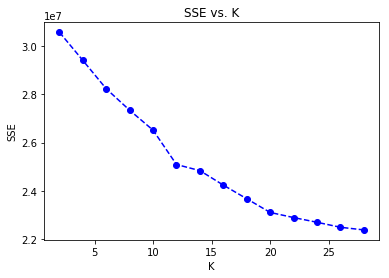

In [79]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

To decide on the best k ,it looks like there is an elbow between 10 and 15. So zoom in on that part to decide.

In [80]:
scores =[]
centers = list(range(10,20))
for center in centers:
    scores.append(get_kmeans_score(azdias_complete_pca, center))
    

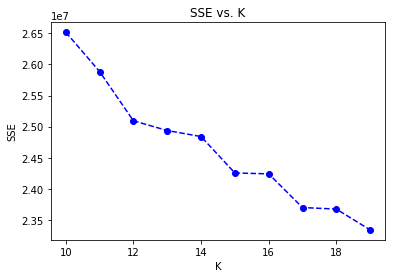

In [81]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

By looking at the above picture, we are getting a clearer idea about what should be the optimal k. Here we can see that there is an elbow at 12. So decided to go with 12 clusters.

In [78]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=12,random_state=49)
model_gen_pop = kmeans.fit(azdias_complete_pca)
clusters_gen_pop = model_gen_pop.predict(azdias_complete_pca)

### Discussion 3.1: Apply Clustering to General Population

By plotting the Sum of Squared errors vs No. of clusters, it looks like there is an elbow between 10 and 15 clusters. So by zooming in on that part , it looks like the elbow is at 12.
So decided to go with 12 clusters.

So used 12 clusters to re fit the k means cluster.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [79]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
customers.shape

(191652, 85)

In [80]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean , customers_incomplete = clean_data(customers)
print(customers_clean.shape)
print(customers_incomplete.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

(115643, 121)
(76009, 79)


In [81]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL_FLAG
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0,0,0,0,0,0,2,1,3,1
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1,0,0,0,0,0,2,3,4,0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0,0,1,0,0,1,4,4,1,0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1,0,0,0,0,0,2,3,4,0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0,0,0,0,0,0,2,2,3,1


In [82]:
customers_clean_1 = scaler.transform(customers_clean)
customers_clean_2 =pd.DataFrame(customers_clean_1,columns=customers_clean.columns)
customers_clean_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE,RURAL_FLAG
0,1.176307,-1.022678,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.856545,1.806129,-1.591638,...,-0.265613,-0.403042,-0.331590,-0.47294,-0.403596,-1.806129,-1.591253,-1.595957,0.082845,1.884409
1,1.176307,0.977825,1.427283,-1.141401,1.114984,-1.221857,1.047073,0.608140,1.806129,-0.273496,...,3.764879,-0.403042,-0.331590,-0.47294,-0.403596,-1.806129,-1.591253,-0.224038,0.749822,-0.530670
2,0.202107,-1.022678,-0.042471,-1.141401,0.394976,0.848830,1.775773,-0.856545,-0.553670,1.044647,...,-0.265613,-0.403042,3.015776,-0.47294,-0.403596,0.553670,-0.213400,0.461922,-1.251108,-0.530670
3,0.202107,-1.022678,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.124203,1.806129,1.044647,...,3.764879,-0.403042,-0.331590,-0.47294,-0.403596,-1.806129,-1.591253,-0.224038,0.749822,-0.530670
4,1.176307,-1.022678,1.427283,-1.141401,1.114984,-1.221857,-1.139028,-0.856545,1.806129,-0.273496,...,-0.265613,-0.403042,-0.331590,-0.47294,-0.403596,-1.806129,-1.591253,-0.909997,0.082845,1.884409


In [83]:
#pca
customers_clean_pca = pca.transform(customers_clean_1)
#clustering
clusters_cust = model_gen_pop.predict(customers_clean_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [84]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
prop_general = []
pop_general = []
pop_customers =[]
prop_customers = []

x = [i+1 for i in range(12)]
for i in range(12):
    pop_general.append((clusters_gen_pop == i).sum())
    prop_general.append(round((clusters_gen_pop == i).sum()/len(clusters_gen_pop)*100,2))
    pop_customers.append((clusters_cust == i).sum())
    prop_customers.append(round((clusters_cust == i).sum()/len(clusters_cust)*100,2))

clusters_both = pd.DataFrame({'cluster' : x,'pop_general':pop_general, 'prop_general' : prop_general,'pop_customers':pop_customers,'prop_customers':prop_customers})
clusters_both


,cluster,pop_customers,pop_general,prop_customers,prop_general
0,1,5090,20633,4.40,3.31
1,2,6711,39756,5.80,6.38
2,3,13731,51307,11.87,8.23
3,4,14023,69113,12.13,11.09
4,5,11120,31274,9.62,5.02
5,6,4201,97858,3.63,15.70
6,7,5786,59986,5.00,9.63
7,8,14497,71139,12.54,11.41
8,9,2523,2783,2.18,0.45
9,10,20884,81086,18.06,13.01


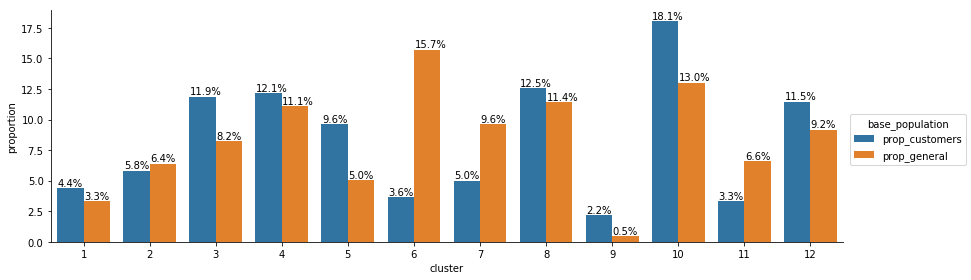

In [85]:
df = pd.DataFrame({'cluster' : x, 'prop_general' : prop_general,'prop_customers':prop_customers})
df = pd.melt(df, id_vars="cluster", var_name="base_population", value_name="proportion")
df
sns.factorplot(x='cluster', y='proportion', hue='base_population', data=df, size=4, aspect=3,kind='bar')
ax = plt.gca()
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x()+0.008, p.get_height()+0.18))
plt.show()

In [86]:
#Getting the number of the deleted rows due to incomplete data from General as well as customer datasets

print("Number of rows deleted for General Population is" ,azdias_incomplete.shape[0])
print("Number of rows deleted for Customer Data is" ,customers_incomplete.shape[0])

Number of rows deleted for General Population is 268012
Number of rows deleted for Customer Data is 76009


In [87]:
#Adding deleted rows from both as an additional cluster
col_list = list(clusters_both.columns)
clusters_both.loc[-1]  = [-1,76009,268012,0,0]
clusters_both.index = clusters_both.index+1
clusters_both.sort_index(inplace=True)
clusters_both['prop_customers'] = round(clusters_both['pop_customers']/clusters_both['pop_customers'].sum()*100,2)
clusters_both['prop_general'] = round(clusters_both['pop_general']/clusters_both['pop_general'].sum()*100,2)
clusters_both

,cluster,pop_customers,pop_general,prop_customers,prop_general
0,-1,76009,268012,39.66,30.07
1,1,5090,20633,2.66,2.32
2,2,6711,39756,3.50,4.46
3,3,13731,51307,7.16,5.76
4,4,14023,69113,7.32,7.75
5,5,11120,31274,5.80,3.51
6,6,4201,97858,2.19,10.98
7,7,5786,59986,3.02,6.73
8,8,14497,71139,7.56,7.98
9,9,2523,2783,1.32,0.31


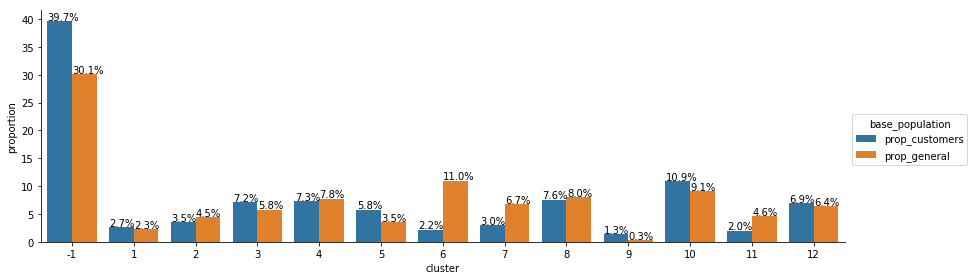

In [88]:
df = clusters_both[['cluster','prop_customers','prop_general']]
df = pd.melt(df, id_vars="cluster", var_name="base_population", value_name="proportion")
df
sns.factorplot(x='cluster', y='proportion', hue='base_population', data=df, size=4, aspect=3,kind='bar')
ax = plt.gca()
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x()+0.008, p.get_height()+0.20))
plt.show()

In [108]:
kmeans.cluster_centers_[9]

array([-0.04330798,  0.04739054,  0.02963715,  0.18551229, -0.04707532,
        0.31895705,  0.17351621, -0.10590918,  0.20511924,  0.04263203,
        0.36751053,  0.08780437,  0.07252668, -0.37307568,  0.13778739,
       -0.08272659,  0.14438925,  0.09877952, -0.11643467, -0.0832451 ,
       -0.16594581, -0.49929695,  0.47403904, -0.04552526,  0.34059919,
        0.09042648,  0.89453781,  0.14666984, -0.83585333,  1.44862869,
       -0.71910055, -0.33022825,  0.15225502, -0.24174863, -0.49946334,
       -0.26865339,  0.12403704,  0.0992245 , -0.31826532, -0.05433429,
       -0.02809105, -0.01863144, -0.26175164,  0.16587701, -0.2843985 ,
        0.11951944,  0.34543801,  0.21529382, -0.16917162,  0.16082004])

In [99]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
#Cluster10,5 and 3 seems to be over represented in the customer data. Not much when considering the incomplete rows
cluster10 = kmeans.cluster_centers_[9]
cluster10 = pd.Series(cluster10)
cluster10.index = cluster10.index +1
cluster10.sort_values(ascending=False)

30    1.448629
27    0.894538
23    0.474039
11    0.367511
47    0.345438
25    0.340599
6     0.318957
48    0.215294
9     0.205119
4     0.185512
7     0.173516
44    0.165877
50    0.160820
33    0.152255
28    0.146670
17    0.144389
15    0.137787
37    0.124037
46    0.119519
38    0.099225
18    0.098780
26    0.090426
12    0.087804
13    0.072527
2     0.047391
10    0.042632
3     0.029637
42   -0.018631
41   -0.028091
1    -0.043308
24   -0.045525
5    -0.047075
40   -0.054334
16   -0.082727
20   -0.083245
8    -0.105909
19   -0.116435
21   -0.165946
49   -0.169172
34   -0.241749
43   -0.261752
36   -0.268653
45   -0.284399
39   -0.318265
32   -0.330228
14   -0.373076
22   -0.499297
35   -0.499463
31   -0.719101
29   -0.835853
dtype: float64

In [101]:
#Principalcomponent 30 and 27 are the 1st and 2nd important components in the cluster10.
#So getting their to 5 +ve and top5 -ve features
print(get_feature_weights(30),get_feature_weights(27))

Top 5 features with positive weights for PC_ 30  are
--------------------------------------------------
GFK_URLAUBERTYP_10.0    0.531680
FINANZTYP_6.0           0.195763
LP_FAMILIE_GROB_4.0     0.185375
LP_FAMILIE_GROB_2.0     0.180940
CAMEO_DEUG_2015_4       0.159759
Name: PC_30, dtype: float64
--------------------------------------------------
--------------------------------------------------
Top 5 features with negative weights for PC_ 30  are
GFK_URLAUBERTYP_11.0   -0.327629
LP_FAMILIE_GROB_3.0    -0.216774
GFK_URLAUBERTYP_5.0    -0.203217
CAMEO_DEUG_2015_2      -0.201147
CAMEO_DEUG_2015_6      -0.154150
Name: PC_30, dtype: float64
Top 5 features with positive weights for PC_ 27  are
--------------------------------------------------
GFK_URLAUBERTYP_10.0    0.323307
CAMEO_DEUG_2015_7       0.264186
CJT_GESAMTTYP_5.0       0.253520
CAMEO_DEUG_2015_6       0.223702
GFK_URLAUBERTYP_5.0     0.215254
Name: PC_27, dtype: float64
--------------------------------------------------
-------

In [102]:
cluster5 = kmeans.cluster_centers_[4]
cluster5 = pd.Series(cluster5)
cluster5.index = cluster5.index +1
cluster5.sort_values(ascending=False)

49    1.241413
45    1.161049
40    0.777419
14    0.469156
2     0.449640
37    0.422537
8     0.412652
32    0.395914
38    0.351129
44    0.317990
9     0.313352
24    0.270893
16    0.162752
13    0.160054
11    0.151465
43    0.137225
21    0.104851
36    0.094555
3     0.079794
28    0.027322
46   -0.014758
4    -0.082928
18   -0.093485
22   -0.107768
26   -0.141097
25   -0.156674
5    -0.156740
6    -0.212893
7    -0.217131
39   -0.239767
15   -0.268008
20   -0.325638
33   -0.335285
10   -0.337358
30   -0.346046
23   -0.375829
29   -0.435175
34   -0.448248
19   -0.468836
27   -0.480704
17   -0.538666
48   -0.647754
12   -0.667241
35   -0.777860
1    -0.801896
50   -0.829279
47   -0.881749
42   -0.909886
41   -1.126456
31   -1.342341
dtype: float64

In [103]:
print(get_feature_weights(49),get_feature_weights(45))

Top 5 features with positive weights for PC_ 49  are
--------------------------------------------------
SHOPPER_TYP_3.0        0.300615
GFK_URLAUBERTYP_7.0    0.300342
ZABEOTYP_3.0           0.274861
HEALTH_TYP             0.248290
KBA05_ANTG2            0.167534
Name: PC_49, dtype: float64
--------------------------------------------------
--------------------------------------------------
Top 5 features with negative weights for PC_ 49  are
SHOPPER_TYP_0.0       -0.294635
GFK_URLAUBERTYP_3.0   -0.285288
ZABEOTYP_6.0          -0.265525
FINANZTYP_4.0         -0.167496
GFK_URLAUBERTYP_8.0   -0.151367
Name: PC_49, dtype: float64
Top 5 features with positive weights for PC_ 45  are
--------------------------------------------------
CAMEO_DEUG_2015_4      0.288391
GFK_URLAUBERTYP_7.0    0.272306
GFK_URLAUBERTYP_6.0    0.196765
CAMEO_DEUG_2015_7      0.174564
CAMEO_DEUG_2015_3      0.165845
Name: PC_45, dtype: float64
--------------------------------------------------
----------------------

In [104]:
cluster3 = kmeans.cluster_centers_[2]
cluster3 = pd.Series(cluster3)
cluster3.index = cluster3.index +1
cluster3.sort_values(ascending=False)

46    1.429740
39    1.036868
31    0.861507
25    0.718967
34    0.659987
28    0.642238
2     0.634022
48    0.483453
37    0.476802
35    0.462699
47    0.458403
41    0.388793
3     0.291661
14    0.286253
22    0.241805
8     0.228815
11    0.218687
9     0.195618
17    0.142708
10    0.090093
12    0.085936
49    0.085514
7     0.078376
20    0.055519
6     0.043987
1     0.043686
30    0.042526
43    0.014399
36   -0.025253
38   -0.030118
23   -0.040674
4    -0.060323
24   -0.090256
13   -0.107307
32   -0.118442
19   -0.127278
5    -0.130105
15   -0.147556
29   -0.153342
50   -0.156441
45   -0.240338
18   -0.265498
33   -0.267344
21   -0.366774
16   -0.384878
27   -0.457371
44   -0.498354
40   -0.576362
26   -0.856091
42   -0.964718
dtype: float64

In [105]:
print(get_feature_weights(46),get_feature_weights(39))

Top 5 features with positive weights for PC_ 46  are
--------------------------------------------------
GFK_URLAUBERTYP_4.0    0.436485
ZABEOTYP_4.0           0.169426
CAMEO_DEUG_2015_4      0.159486
SHOPPER_TYP_2.0        0.121567
ANZ_HH_TITEL           0.120876
Name: PC_46, dtype: float64
--------------------------------------------------
--------------------------------------------------
Top 5 features with negative weights for PC_ 46  are
GFK_URLAUBERTYP_2.0   -0.503099
LP_FAMILIE_GROB_3.0   -0.259379
CAMEO_DEUG_2015_1     -0.242374
SHOPPER_TYP_0.0       -0.184663
GFK_URLAUBERTYP_1.0   -0.180895
Name: PC_46, dtype: float64
Top 5 features with positive weights for PC_ 39  are
--------------------------------------------------
GFK_URLAUBERTYP_2.0     0.319082
GFK_URLAUBERTYP_12.0    0.317280
GFK_URLAUBERTYP_4.0     0.304351
SOHO_KZ                 0.248392
GFK_URLAUBERTYP_6.0     0.228533
Name: PC_39, dtype: float64
--------------------------------------------------
-----------------

In [109]:
cluster10_orig = scaler.inverse_transform(pca.inverse_transform(cluster10))
cluster10_orig = pd.Series(cluster10_orig).round()
cluster10_orig.index = azdias_complete.columns
cluster10_orig

ALTERSKATEGORIE_GROB     3.0
ANREDE_KZ                2.0
FINANZ_MINIMALIST        3.0
FINANZ_SPARER            3.0
FINANZ_VORSORGER         4.0
FINANZ_ANLEGER           3.0
FINANZ_UNAUFFAELLIGER    3.0
FINANZ_HAUSBAUER         3.0
GREEN_AVANTGARDE         0.0
HEALTH_TYP               2.0
RETOURTYP_BK_S           3.0
SEMIO_SOZ                4.0
SEMIO_FAM                4.0
SEMIO_REL                4.0
SEMIO_MAT                4.0
SEMIO_VERT               4.0
SEMIO_LUST               4.0
SEMIO_ERL                5.0
SEMIO_KULT               4.0
SEMIO_RAT                4.0
SEMIO_KRIT               4.0
SEMIO_DOM                5.0
SEMIO_KAEM               4.0
SEMIO_PFLICHT            4.0
SEMIO_TRADV              4.0
SOHO_KZ                  0.0
VERS_TYP                 2.0
ANZ_PERSONEN             2.0
ANZ_TITEL               -0.0
HH_EINKOMMEN_SCORE       4.0
                        ... 
LP_FAMILIE_GROB_5.0      0.0
LP_STATUS_GROB_1.0       0.0
LP_STATUS_GROB_2.0       0.0
LP_STATUS_GROB

In [113]:
cluster5_orig = scaler.inverse_transform(pca.inverse_transform(cluster5))
cluster5_orig = pd.Series(cluster5_orig).round()
cluster5_orig.index = azdias_complete.columns
cluster5_orig

ALTERSKATEGORIE_GROB     3.0
ANREDE_KZ                2.0
FINANZ_MINIMALIST        4.0
FINANZ_SPARER            2.0
FINANZ_VORSORGER         4.0
FINANZ_ANLEGER           2.0
FINANZ_UNAUFFAELLIGER    2.0
FINANZ_HAUSBAUER         3.0
GREEN_AVANTGARDE         0.0
HEALTH_TYP               2.0
RETOURTYP_BK_S           4.0
SEMIO_SOZ                4.0
SEMIO_FAM                3.0
SEMIO_REL                3.0
SEMIO_MAT                3.0
SEMIO_VERT               4.0
SEMIO_LUST               5.0
SEMIO_ERL                5.0
SEMIO_KULT               3.0
SEMIO_RAT                3.0
SEMIO_KRIT               5.0
SEMIO_DOM                4.0
SEMIO_KAEM               4.0
SEMIO_PFLICHT            3.0
SEMIO_TRADV              3.0
SOHO_KZ                  0.0
VERS_TYP                 1.0
ANZ_PERSONEN             2.0
ANZ_TITEL                0.0
HH_EINKOMMEN_SCORE       4.0
                        ... 
LP_FAMILIE_GROB_5.0      0.0
LP_STATUS_GROB_1.0       0.0
LP_STATUS_GROB_2.0       0.0
LP_STATUS_GROB

In [106]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#Cluster6 is the underrepresented cluster in the customer data
cluster6 = kmeans.cluster_centers_[5]
cluster6 = pd.Series(cluster6)
cluster6.index = cluster6.index +1
cluster6.sort_values(ascending=False)

39    0.749572
1     0.581536
33    0.524132
26    0.498384
24    0.451292
50    0.355414
38    0.296624
23    0.248479
16    0.223915
46    0.220797
19    0.219269
43    0.200388
32    0.185897
29    0.159583
18    0.154596
20    0.137498
25    0.128194
35    0.126111
45    0.056141
13    0.046937
8     0.017281
10    0.001767
40    0.001504
9    -0.007290
22   -0.012895
14   -0.047952
49   -0.075491
6    -0.075958
42   -0.122856
3    -0.123260
17   -0.140346
48   -0.143903
27   -0.148956
21   -0.150298
12   -0.156372
30   -0.160548
37   -0.168300
34   -0.175750
7    -0.202447
2    -0.242527
41   -0.263783
5    -0.292138
44   -0.318624
31   -0.346688
4    -0.370556
11   -0.412859
36   -0.429555
15   -0.476191
28   -0.570099
47   -0.706282
dtype: float64

In [107]:
print(get_feature_weights(39),get_feature_weights(1))

Top 5 features with positive weights for PC_ 39  are
--------------------------------------------------
GFK_URLAUBERTYP_2.0     0.319082
GFK_URLAUBERTYP_12.0    0.317280
GFK_URLAUBERTYP_4.0     0.304351
SOHO_KZ                 0.248392
GFK_URLAUBERTYP_6.0     0.228533
Name: PC_39, dtype: float64
--------------------------------------------------
--------------------------------------------------
Top 5 features with negative weights for PC_ 39  are
GFK_URLAUBERTYP_9.0   -0.371112
GFK_URLAUBERTYP_1.0   -0.258354
GFK_URLAUBERTYP_5.0   -0.213449
GFK_URLAUBERTYP_8.0   -0.187063
LP_FAMILIE_GROB_3.0   -0.148352
Name: PC_39, dtype: float64
Top 5 features with positive weights for PC_ 1  are
--------------------------------------------------
LP_STATUS_GROB_1.0    0.196077
PLZ8_ANTG3            0.185699
CAMEO_WEALTH          0.179952
HH_EINKOMMEN_SCORE    0.179946
PLZ8_ANTG4            0.179636
Name: PC_1, dtype: float64
--------------------------------------------------
------------------------

In [114]:
cluster6_orig = scaler.inverse_transform(pca.inverse_transform(cluster6))
cluster6_orig = pd.Series(cluster6_orig).round()
cluster6_orig.index = azdias_complete.columns
cluster6_orig

ALTERSKATEGORIE_GROB     2.0
ANREDE_KZ                2.0
FINANZ_MINIMALIST        2.0
FINANZ_SPARER            3.0
FINANZ_VORSORGER         3.0
FINANZ_ANLEGER           3.0
FINANZ_UNAUFFAELLIGER    3.0
FINANZ_HAUSBAUER         4.0
GREEN_AVANTGARDE         0.0
HEALTH_TYP               2.0
RETOURTYP_BK_S           3.0
SEMIO_SOZ                4.0
SEMIO_FAM                5.0
SEMIO_REL                5.0
SEMIO_MAT                4.0
SEMIO_VERT               4.0
SEMIO_LUST               4.0
SEMIO_ERL                4.0
SEMIO_KULT               5.0
SEMIO_RAT                4.0
SEMIO_KRIT               4.0
SEMIO_DOM                5.0
SEMIO_KAEM               4.0
SEMIO_PFLICHT            5.0
SEMIO_TRADV              4.0
SOHO_KZ                  0.0
VERS_TYP                 2.0
ANZ_PERSONEN             1.0
ANZ_TITEL               -0.0
HH_EINKOMMEN_SCORE       5.0
                        ... 
LP_FAMILIE_GROB_5.0      0.0
LP_STATUS_GROB_1.0       1.0
LP_STATUS_GROB_2.0       0.0
LP_STATUS_GROB

### Discussion 3.3: Compare Customer Data to Demographics Data

In the cluster analysis and comparison which we did with out using the incomplete data, from the chart we could see that there are some clear mismatches between the customer data and general population.
We are able to identify some definite target segments for the Client.Cluster10,Cluster5,Cluster12 ,Cluster3 etc are some of them. We also are able to identify an outside the target group which can be identified by the underrepresented cluster in the customer data, which is Cluster6. So these people should not be targetted.

But once we included, the deleted rows as a cluster for comparison, the entire scenario changed. Now we are getting more matches between the 2 populations. The customer population is well represented in the general population with few exceptions.
Here we are not able to clearly identify the target segment. But we can clearly a non target segment, which is cluster6.

This shows that the we were loosing an important segment of the target population when we dropped the incomplete rows. So if we had used that, then we could have got better results and might have been clearly able to identify the target segment.

From the earlier analysis of some of the key features like house hold income, social status etc on the incomplete data we got to know that they were High income group, which is an obvious target for the company. By deleting those we are losing out.

Again from what we have , if we try to identify the target group for the company, we can see that they are,

**Couples or families from middle class to lower middle class who enjoys vactions and with inconspicous financial types .Their preffered buying channels are advertising and cross channel enthusiast.
They loves shopping and are mostly demanding shoppers.
These characterestics of the target segment are coming out through all the identified target clusters like cluster10, cluster5 and cluster3.**

If we examine the **cluster6** which is non target population we can see that they are **Low income earners,who live in dense areas with poorer households.** So company should not target these people.

So actually as a correct step what we have to do is go back and consider the entire data for the analysis and handle the missing rows in a way and redo the analysis.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.